<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/split-and-simple-perturb/sequences/P2C1_Optimization/P2C1_Sequence1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **2.1.1: Optimization in One Dimension: Developing Intuition**
In the first part of the book we gained insight into what the brain is for: the primary function of the brain is the rapid acquisition of adaptive behaviours. Now that we know what a brain is for, we are going to start thinking about how it does what it needs to do. Instead of taking a bottom up approach grounded in observed physiological mechanisms, we are going to use a problem oriented, top down approach. That is, we will think about what problems the brain is solving and then survey the various physiological mechanisms that could feasibly implement algorithms that solve those problems. We will start with problems that are simple to understand from a statistical and mathematical perspective; basic optimization and then a broad sub-field of machine learning known as supervised learning. To develop and ground our intuitions, in particular around problem scale, we start with some very simple problems.

In our last chapter, 1.4 Life is Reinforcement Learning, we introduced the idea that within life time learning of an organism can be understood as solving a particular set of reinforcement learning problems selected for by the evolutionary process. In particular we view the evolutionary process as selecting both the intrinsic reward signals (i.e. which kinds of base sensory inputs are intrinsically rewarding) and the neural plasticity rules by which the sensory to behaviour function is updated using these reward signals. That is evolution selects for both the goals and the method of learning, choosing sensory grounded goals that guide behaviour towards being adaptive in the evolutionary sense (survival and reproduction) and learning methods that *quickly* develop these adaptive behaviours. We will come back to RL in the 4th part of this book but before we do we want to ground ourselves in a general optimization perspective.

### Objective: Solve simple optimization problems using perturbation methods, and connect these methods with physiological neural plasticity mechanisms.

In this sequence we will:

* Introduce and review the fundamental ideas of optimization.

* Introduce the perturb -> measure -> update learning rule

* Introduce a simple visual (binary) discrimination tasks

* Show how perturb -> measure -> update can be used to train a simple threshold striking rule that solves this binary discrimination problem.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P2C1_S1"

Best feature is 21
Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 2.1.1.1: Optimizing a Polynomial Analytically



In general, optimization problems are of the form: "Find some set of parameters or values, say $x$, such that some other scalar valued quantity which depends in some way on those values, i.e. a function of $x$, calli it $f(x)$, is as large (or small) as possible, subject to some constraints on the possible values of $x$." In other words, we're looking for the best setting on a dial (the value of $x$) that maximizes or minimizes our outcome (the value of $f(x)$), within certain limits (constraints on $x$).

Here's an example. Find a value of $x$ on the interval $[-2, 2]$ such that $f(x) = -x^2 + 2x + 3$ is as large as possible. This might be written more tersely with symbols as:

$$\underset{x\in[-2,2]}{\arg \max}(-x^2 + 2x + 3)  $$

If you have taken (and remember!) a calculus course you might think to yourself, "Oh, I know how to do that". First we take the derivative,

$$
\frac{\text{d}}{\text{d}x} -x^2 + 2x + 3 = -2x + 2
$$

then we set that equal to zero and solve for the extrema. Since the derivative is the instantaneous rate of change of $f(x)$ with respect to $x$, setting the derivative to zero helps us find the peaks or valleys of the equation, indicating where $f(x)$ is at its largest or smallest values within our constraints.

$$
\begin{align}
-2x + 2 &= 0 \\
x &= 1
\end{align}
$$

If you really dig into your calculus memories (if you have them) you might recall that you also need to check the concavity (whether the curve bends upwards or downwards) to see if this zero-derivative point is a maximum or a minimum. In the same way that the first derivative gives the slope of $f(x)$ the second derivative gives the curvature.
$$
\left. \frac{\text{d}^2}{\text{d}x^2} -x^2 + 2x + 3 \right|_{x=1}= -2
$$

The negative curvature at $x=1$ tells us that the curve bends downwards there, so the zero-derivative point, $x=1$, is a maximum. Looking at the picture below, this all seems to be correct.

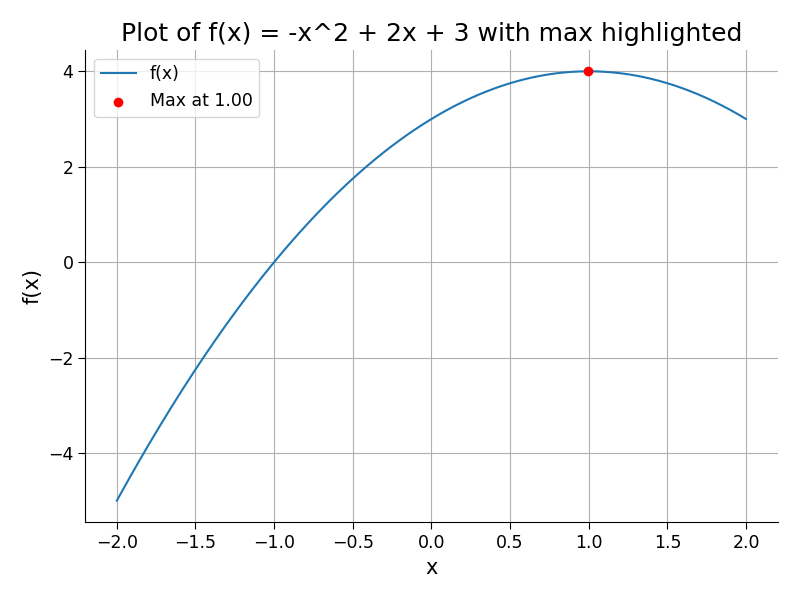

In [2]:
# @markdown **Run this cell** to plot the function we are optimizing

def f(x):
  return -(x-1)**2 + 4

x = np.linspace(-2, 2, 400)
y = f(x)

ymax = np.max(y)
xmax = x[np.argmax(y)]

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the function
ax.plot(x, y, label='f(x)')
ax.scatter(xmax, ymax, color='red', label=f'Max at {xmax:.2f}', zorder=5)
ax.set_title('Plot of f(x) = -x^2 + 2x + 3 with max highlighted')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
plt.grid(True)
plt.show()


If the parabola were opening up instead of down the maximum would have been on the edges, so we should have checked those as well.

Although this particular problem was framed in the abstract language of polynomials and math symbols, we can view the brain's plasticity as a form of optimization on the 'parameters' of the brain. In such cases constraints like $x\in[-2,2]$ are critical as they correspond to physiologically informed constraints. Just as we look for the optimal value of $x$ within constraints, the brain adjusts its neural 'parameters' within the limits of physiological constraints to optimize behavior.

**Math Exercise**
1. Use the calculus principles we've discussed and apply them to derive a general formula for finding the maxima or minima of any parabola, parameterized by coefficients $a$, $b$, and $c$ as

$$f(x) = a(x-b)^2 + c$$

(Answer: The vertex of the parabola, occurring at $x=b$, is either the global maximum or minimum value. Whether it is a maximum or minimum is determined by the curvature of the parabola, which is given by coefficient $a$. Specifically, the vertex represents a minimum when $a$ is positive and the parabola opens upwards, and a maximum when $a$ is negative and the parabola opens downwards. The value at this vertex, $f(b) = c$, is thus either the maximum or minimum value depending on $a$'s sign. Virtually all practical optimizations problems involve constraints. With $x$ constrained to an interval, two possible cases arise. First, if the vertex falls outside this interval, both the maximum and minimum values within the constraints will occur at the boundary points. Second, if the vertex falls within the constrained interval, then either the vertex is a minimum (with $a$ positive) and the maximum value of the function will be found at a boundary point, or the vertex is a maximum (with $a$ negative) and the minimum value will similarly be located at the boundary.)


In [3]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 2.1.1.2: Optimizing a Polynomial with Propose and Reject
Now, the analytic method above of taking derivatives, finding zeros, and checking concavity offers a clear solution to optimization problems. However, these sorts of computations are unlikely to serve as model of low level neural plasciticty, for several interelated reasons having to do with scalability, complexity, and information requirements, each of which we will unpack in more detail later. For now we take as given that something like analytic optimization is likely not what is happening in the brain. This raises the question of whether there are other more simple methods for solving this kind of problem, methods that are more likely to have clearer correspondence witht the physilology of th brain.

One of the simplest optimization strategies that exists, and one that proved quite effective earlier in this book, is propose and reject. Indeed, evolution through natural selection is roughly running a kind of propose (new variants through mutation and recombination) and accept or reject (through selective survival and reproduction) algorithm on the living world. To further develop our intuitions, let's apply this approach to our familiar optimization challenge of finding the value of $x$ that maximizes a quadratic function $f(x)$.

Propose and reject algorithms offer a conceptual simplicity that makes them easier to envision as mechanisms within the brain. Imagine synaptic weights between neurons undergoing slight, temporary adjustments. If these adjustments yield a positive outcome, they are reinforced and made more permanent, laying the groundwork for future experimentation. This is, admittedly, an oversimplification, but it outlines a process that aligns more closely with what is known of the underlying physiology of neural plasticity at the micro level and behavioural plasticity at the macro level: iterative, trial and error learning.

Below, is an interative implementation of the propose-and-reject method applied to finding the maximum of a quadratic function. Stepping through the process will give a feel for the iterative nature of decision-making. Start by clicking 'Propose' to sample a new proposed $x$ value. Then, decide whether to 'Accept' or 'Reject' the proposed point based on a comparison with the previous point. Your goal is to find the peak of the curve. 'Show History' is turned on to start so you can see all of the previous steps in the process. You can toggle the 'Show Function' button to plot the polynomial we are optimizing.

In [4]:
# @title Stepping Through Optimization with Propose and Reject
# @markdown **Run this cell** to try your hand at manually finding the maximum of a quadratic function using propose and reject.
class InteractivePolynomialProposeReject:
  def __init__(self,
               polynomial_max = 1,
               bounds=(-4, 4),
               step_size=0.5, seed=None):
    self.polynomial_max = polynomial_max
    self.polynomial = lambda x: -(x - polynomial_max)**2 + 4
    self.bounds = bounds
    self.step_size = step_size
    self.rng = np.random.default_rng(seed)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.proposals_evaluated = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))
    self.propose = widgets.Button(description='Propose')
    self.accept = widgets.Button(description='Accept')
    self.reject = widgets.Button(description='Reject')
    self.reset = widgets.Button(description='Reset')
    self.accept.disabled = True  # Disable since there's no proposal initially
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.reject.disabled = True  # Disable since there's no proposal initially
    self.show_curve = widgets.ToggleButton(value=False, description='Show Function')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    # Arrange widgets in a layout
    buttons_layout = widgets.VBox([self.propose,
        widgets.HBox([self.accept, self.reject]),
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])
    #bind actions to handlers
    self.propose.on_click(self.on_propose_clicked)
    self.accept.on_click(self.on_accept_clicked)
    self.reject.on_click(self.on_reject_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    # Initial plot commands return line objects, keep references to them
    self.line_polynomial, = self.ax.plot(x_vals, y_vals, alpha=1.0, label='Polynomial Curve')
    self.point_current, = self.ax.plot([self.current_x], [self.current_y], 'bo', label='Current')
    self.point_proposed, = self.ax.plot([], [], 'rx', label='Proposed')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_propose_clicked(self, button):
    self.proposals_evaluated += 1
    perturbation = self.rng.standard_normal() * self.step_size
    self.proposed_x = self.current_x + perturbation
    self.proposed_y = self.polynomial(self.proposed_x)
    self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    self.fig.canvas.draw_idle()
    #self.update_plot()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Proposed x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f' Current x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print("Click accept or reject to accept or reject this proposed x?")
      print(f'Proposals evaluated so far: {self.proposals_evaluated}')
    self.accept.disabled = False
    self.reject.disabled = False
    self.propose.disabled = True

  def on_accept_clicked(self, button):
    with self.narration_display:
      clear_output(wait=True)
      print(f'Accepted x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f'Click propose to try a new value.')
    self.x_history.append(self.current_x)
    self.y_history.append(self.current_y)
    self.current_x = self.proposed_x
    self.current_y = self.proposed_y
    self.proposed_x = None
    self.proposed_y = None
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False

  def on_reject_clicked(self, button):
    with self.narration_display:
      clear_output(wait=True)
      print(f'Rejected x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f' Keeping x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print(f'Click propose to try a new value.')
    self.proposed_x = None
    self.proposed_y = None
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.polynomial_max = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.polynomial = lambda x: -(x - self.polynomial_max)**2 + 5
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    self.line_polynomial.set_data(x_vals, y_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    padding = (max_y - min_y) * 0.1  # Add some padding to the limits
    self.ax.set_ylim(min_y - padding, max_y + padding)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



ippr = InteractivePolynomialProposeReject()
display(ippr.fig.canvas)
clear_output()
display(ippr.ui)

So propose and reject works pretty well, but there is a notable limitation. Whenever the proposed step is in the 'wrong' direction, we don't make any progress towards a better $x$ value. Although propose and reject has a nice ratcheting feature—that is, we never pick an $x$ value that is worse than the one we currently have—we can potentially waste a lot of evaluations on test steps in the wrong direction. To overcome this limitation, we can introduce a tweak: making updates in the opposite direction of a 'wrong' step. This tweak shifts our evaluative question from 'Is this a good new point to jump to?' to 'In which direction should I change the parameter?'. This shift helps us avoid 'wasting' unfavorable proposals. Specifically, by using every proposal—favorable or not—for guidance, this method ensures that each test step, regardless of its initial direction, contributes valuable information for parameter adjustment. However, this leaves open the question of how far to step in that opposite direction. For now, let's just try stepping as far as the initially proposed step but in the opposite direction. You can try out this modified version of the algorithm in the interactive widget below.

In [5]:
# @title Manual Optimization with Modified Propose and Reject (always step)
# @markdown **Run this cell** to try your hand at manually finding the maximum of a quadratic function with this modified Propose and Reject method.
class InteractivePolynomialTestStep:
  def __init__(self,
               polynomial_max = 1,
               bounds=(-4, 4),
               step_size=0.5, seed=None):
    self.polynomial_max = polynomial_max
    self.polynomial = lambda x: -(x - polynomial_max)**2 + 4
    self.bounds = bounds
    self.step_size = step_size
    self.rng = np.random.default_rng(seed)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.proposals_evaluated = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))
    self.propose = widgets.Button(description='Propose')
    self.take_step = widgets.Button(description='Take Step')
    self.reset = widgets.Button(description='Reset')
    self.take_step.disabled = True  # Disable since there's no proposal initially
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=False, description='Show Function')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    # Arrange widgets in a layout
    buttons_layout = widgets.VBox([
        widgets.HBox([self.propose, self.take_step]),
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])
    #bind actions to handlers
    self.propose.on_click(self.on_propose_clicked)
    self.take_step.on_click(self.on_take_step_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    # Initial plot commands return line objects, keep references to them
    self.line_polynomial, = self.ax.plot(x_vals, y_vals, alpha=1.0, label='Polynomial Curve')
    self.point_current, = self.ax.plot([self.current_x], [self.current_y], 'bo', label='Current')
    self.point_proposed, = self.ax.plot([], [], 'rx', label='Proposed')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_propose_clicked(self, button):
    self.proposals_evaluated += 1
    perturbation = self.rng.standard_normal() * self.step_size
    self.proposed_x = self.current_x + perturbation
    self.proposed_y = self.polynomial(self.proposed_x)
    self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    self.fig.canvas.draw_idle()
    #self.update_plot()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Proposed x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f' Current x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print("Click take step to update x?")
      print(f'Proposals evaluated so far: {self.proposals_evaluated}')
    self.take_step.disabled = False
    self.propose.disabled = True

  def on_take_step_clicked(self, button):
    if self.proposed_y > self.current_y:
      with self.narration_display:
        clear_output(wait=True)
        print('Proposed is better stepping to proposed')
        print(f'Step to x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
        print(f'Click propose to try a new value.')
      self.x_history.append(self.current_x)
      self.y_history.append(self.current_y)
      self.current_x = self.proposed_x
      self.current_y = self.proposed_y
      self.proposed_x = None
      self.proposed_y = None
      self.point_current.set_data([self.current_x], [self.current_y])
      self.points_history.set_data(self.x_history, self.y_history)
      self.point_proposed.set_data([], [])
    elif self.proposed_y < self.current_y:
      mirror_x = self.current_x - (self.proposed_x - self.current_x)
      mirror_y = self.polynomial(mirror_x)
      with self.narration_display:
        clear_output(wait=True)
        print('Proposed is not as good as current, going in the opposite direction.')
        print(f'Step to x: {mirror_x:.3f}, y: {mirror_y:.3f}.')
        print(f'Click propose to try a new value.')
      self.x_history.append(self.current_x)
      self.y_history.append(self.current_y)
      self.current_x = mirror_x
      self.current_y = mirror_y
      self.proposed_x = None
      self.proposed_y = None
      self.point_current.set_data([self.current_x], [self.current_y])
      self.points_history.set_data(self.x_history, self.y_history)
      self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()
    self.take_step.disabled = True
    self.propose.disabled = False

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.polynomial_max = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.polynomial = lambda x: -(x - self.polynomial_max)**2 + 5
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    self.line_polynomial.set_data(x_vals, y_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    padding = (max_y - min_y) * 0.1  # Add some padding to the limits
    self.ax.set_ylim(min_y - padding, max_y + padding)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.take_step.disabled = True
    self.propose.disabled = False
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



ipts = InteractivePolynomialTestStep()
display(ipts.fig.canvas)
clear_output()
display(ipts.ui)

This modified propose and reject is likely more efficient at first, especially in moving quickly towards the general area of the maximum. However, an issue arises near the maximum value: the risk of "over-shooting" increases, and unlike the original version, this method can step to worse $x$ values because it lacks a ratcheting mechanism. One way to mitigate this issue is to fiddle with step size, but in doing so we will always face a tradeoff. Large step sizes are helpful in the beginning to quickly get in the rough neighbourhood of the maximum and smaller step sizes are better once we are close to the maximum to dial in the maximum precisely. Without a sense of how close or far away the maximum is, it is difficult to choose an appropriate step size.

In [6]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 2.1.1.3 Optimizing a Polynomial with Perturb-Measure-Step

One way to get around the limitations we've encountered in propose and reject (and modified propose and reject) is to dive a little deeper into the insights possible from evaluating proposed values. Previously, with propose and reject, we only ask, "Is this better?" in modified propose and reject, this becomes "Is this the correct direction for our step?" However, we can pose and answer a much more sophisticated question using the same information: "Given the comparison of this proposed $x$ to the current value, how does $f(x)$ change with $x$ near our current position, and based on this, in which direction and how far should we step?" Essentially, this boils down to assessing the slope of the line connecting our current and proposed points and then updating $x$ in a direction proportional to this slope. In this way, the slope informs us not only about the direction but also about the appropriate distance for our next step.

Previously, in the propose-and-reject method, the test point and the parameter adjustment were effectively synonymous. Now, we distinguish between them: the test point serves to inform the parameter's next iteration, typically without being the next step itself. This allows for a more refined approach, where evaluations at the current point and a nearby test point guide the optimization process, enhancing both the efficiency and precision of our search for the maximum.

Use the interactive widget below to step through the perturb-measure-step process we've outlined to see how the slop between the current point and a test point can efficiently guide parameter updates.

In [7]:
# @title Optimization with Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the maximum of a quadratic function using a perturb-measure-step approach.
class InteractivePolynomialSlopeStepper:
  def __init__(self,
               polynomial_max = 1,
               bounds=(-2, 2),
               test_step_size=0.1,
               x_step_size=0.2,
               adjustable_step_size=False,
               seed=None):
    self.polynomial_max = polynomial_max
    self.polynomial = lambda x: -(x - polynomial_max)**2 + 5
    self.bounds = bounds
    self.test_step_slider = widgets.FloatSlider(value=test_step_size, min=-0.5, max=0.5, step=0.01,
                                                    description='Test Step:', readout=True, readout_format='.2f')
    self.x_step_slider = widgets.FloatSlider(value=x_step_size, min=0.01, max=1.5, step=0.01,
                                                    description='x Step:', readout=True, readout_format='.2f')
    self.adjustable_step_size = adjustable_step_size
    self.rng = np.random.default_rng(seed)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.test_x = None
    self.test_y = None
    self.step_x = None
    self.step_y = None
    self.x_history = []
    self.y_history = []
    self.points_tested = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))

    self.perturb = widgets.Button(description='Perturb')
    self.measure = widgets.Button(description='Measure')
    self.measure.disabled = True
    self.step = widgets.Button(description='Step')
    self.step.disabled = True

    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=False, description='Show Function')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    if self.adjustable_step_size:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        self.test_step_slider,
        self.x_step_slider,
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    else:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])

    #bind actions to handlers
    self.perturb.on_click(self.on_perturb_clicked)
    self.measure.on_click(self.on_measure_clicked)
    self.step.on_click(self.on_step_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')
    self.x_step_slider.observe(self.on_x_step_slider_changed, 'value')
    self.test_step_slider.observe(self.on_test_step_slider_changed, 'value')

  def on_x_step_slider_changed(self, change):
    self.step_x = self.current_x + self.x_step_slider.value * self.slope
    self.step_y = self.slope * self.step_x + self.y_intercept
    self.step_point.set_data([self.step_x], [self.step_y])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()

  def on_test_step_slider_changed(self, change):
    if self.test_step_slider.value == 0:
      # Set to a default non-zero value
      self.test_step_slider.value = 0.01
      with self.narration_display:
        print(f"Test step size of 0 cannot be used to calculate slope. Using 0.01 to avoid division by zero in slope calculation.")
    self.test_x = self.current_x + self.test_step_slider.value
    self.test_y = self.polynomial(self.test_x)
    self.test_point.set_data([self.test_x], [self.test_y])
    if self.step_x is not None:
      rise = self.test_y - self.current_y
      run = self.test_x - self.current_x
      self.slope = rise / run
      self.y_intercept = self.current_y - self.slope * self.current_x
      x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
      y_vals = self.slope * x_vals + self.y_intercept
      self.step_line.set_data(x_vals, y_vals)
      self.step_x = self.current_x + self.x_step_slider.value * self.slope
      self.step_y = self.slope * self.step_x + self.y_intercept
      self.step_point.set_data([self.step_x], [self.step_y])
      y_min, y_max = self.ax.get_ylim()
      self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    # Initial plot commands return line objects, keep references to them
    self.point_current, = self.ax.plot([self.current_x], [self.current_y], 'bo', label='Current')
    self.test_point, = self.ax.plot([], [], 'rx', label='Test Point')  # Empty data to start
    self.step_point, = self.ax.plot([], [], 'go', label='Step Point')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.line_polynomial, = self.ax.plot(x_vals, y_vals, alpha=1.0, label='Polynomial Curve')
    self.slope = 0
    self.y_intercept = self.current_y - self.slope * self.current_x
    self.step_line, = self.ax.plot([], [], 'r', label='Measure')
    self.step_vline, = self.ax.plot([], [], 'g', linestyle='--')
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button):
    self.points_tested += 1
    self.test_x = self.current_x + self.test_step_slider.value
    self.test_y = self.polynomial(self.test_x)
    self.test_point.set_data([self.test_x], [self.test_y])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test x: {self.test_x:.3f}, y: {self.test_y:.3f}.')
      print(f'Current x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print("Click measure to evaluate the slope based on this test point")
    self.measure.disabled = False
    self.perturb.disabled = True

  def on_measure_clicked(self, button):
    rise = self.test_y - self.current_y
    run = self.test_x - self.current_x
    self.slope = rise / run
    self.y_intercept = self.current_y - self.slope * self.current_x
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.slope * x_vals + self.y_intercept
    self.step_line.set_data(x_vals, y_vals)
    self.step_x = self.current_x + self.x_step_slider.value * self.slope
    self.step_y = self.slope * self.step_x + self.y_intercept
    self.step_point.set_data([self.step_x], [self.step_y])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Based on slope measurement proposed step from {self.current_x:.3f} to {self.step_x:.3f}')
      print("Click step, to make the step.")

    self.step.disabled = False
    self.measure.disabled = True

  def on_step_clicked(self, button):
    new_y = self.polynomial(self.step_x)
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to x: {self.step_x:.3f}')
      print(f'Actual y value there is {new_y:.3f}')
      print(f'Click perturb to test a new value.')
    self.x_history.append(self.current_x)
    self.y_history.append(self.current_y)
    self.points_history.set_data(self.x_history, self.y_history)
    self.current_x = self.step_x
    self.current_y = new_y
    self.point_current.set_data([self.current_x], [self.current_y])
    self.test_x = None
    self.test_y = None
    self.test_point.set_data([], [])
    self.step_x = None
    self.step_y = None
    self.step_point.set_data([], [])
    self.step_line.set_data([], [])
    self.step_vline.set_data([], [])
    self.fig.canvas.draw_idle()
    self.step.disabled = True
    self.perturb.disabled = False

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.polynomial_max = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.polynomial = lambda x: -(x - self.polynomial_max)**2 + 5
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    self.line_polynomial.set_data(x_vals, y_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    padding = (max_y - min_y) * 0.1  # Add some padding to the limits
    self.ax.set_ylim(min_y - padding, max_y + padding)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.test_x = None
    self.test_y = None
    self.step_x = None
    self.step_y = None
    self.x_history = []
    self.y_history = []
    self.step.disabled = True
    self.perturb.disabled = False
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.test_point.set_data([], [])
    self.step_point.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



ipss = InteractivePolynomialSlopeStepper()
display(ipss.fig.canvas)
clear_output()
display(ipss.ui)

Wow, that works great. We consistently move in the correct direction: taking larger steps when we're further from the maximum and gradually reducing our step size as we approach it. This ensures that even if we overshoot, we're never too far from the maximum, minimizing any potential backtracking.

For those with a background in calculus, the success of this method might not come as a surprise. The slope between two closely spaced test points serves as an approximation of the derivative. By aligning our step sizes with this slope—both in magnitude and direction—we effectively harness the principle of gradient ascent, which naturally leads to smaller steps as we near the peak. This gradient-based approach ensures continuous progress towards a maximum, with the rare exceptions of slight overshoots when we're very close to the maximum goal. Fortunately, even these overshots are corrected in subsequent steps, given sufficiently small test and parameter step sizes.

To get a sense of how both test step size and parameter step size impact the rate of convergence on the maximum, use the sliders to play with these two different meta-parameters of the optimization process in the widget below.

In [8]:
# @title Playing with step sizes in Perturb-Measure-Step
# @markdown **Run this cell** to play with the effect of step-size on the perturb-measure-step approach.
ipss2 = InteractivePolynomialSlopeStepper(adjustable_step_size=True)
display(ipss2.fig.canvas)
clear_output()
display(ipss2.ui)

**Exploration Exercise:**

In the widget above, adjust the `x Step` and `Test Step` size sliders to explore the following scenarios:
1. **Gradual Approach without Overshooting:** Adjust the step sizes so that the current value of $x$ slowly approaches the maximum without overshooting. Aim for a scenario where $x$ gets increasingly closer to the maximizing value but never quite reaches or surpasses it.
2. **Controlled Chattering:** Set the step sizes to allow the current value of $x$ to slowly approach the maximum but with overshoots in each iteration (after possibly a few initial iterations). This behavior, known as chattering, can still be acceptable as long as the process is overall converging on the optimal value.
3. **Unstable Chattering:** Adjust the steps to cause the value of $x$ to consistently overshoot and end up further away from the optimal value with each iteration. This scenario represents unstable chattering, which prevents the optimization process from maintaining $x$ close to the optimal value.

**Hint:** Click the "Show Function" button to see the curve you're optimizing against. Visualizing the function can provide valuable insights into how different step sizes affect the optimization journey towards the maximum.


Now that we've covered some foundational optimization ideas, we can start to consider how these ideas might be applied to the learning challenges faced by organisms—and, more specifically, their brains—in the natural world. We'll start with applying these ideas in simple, illustrative scenarios that roughly abstract the types of challenges living organisms navigate in their quest to survive and thrive. We will still be a long way off from anything a brain is likely to be doing, but this is good step towards bridging the gap between abstract optimization and tangible, adaptive neural plasticity.

In [9]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")


#2.1.1.4: Optimizing Behaviour with Perturb-Measure-Step: The Optimal Striking Threshold

In previous chapters we motivated much of our modeling using a binary classification problem in which a lurking predator must choose between striking and not striking based on sensory input. Initially, we viewed the behavioral map from sensory input to action as genetically determined. However, we concluded the chapter on evolution by highlighting the evolutionary advantage of at least partially learning these sensory-behaviour maps within an organism's lifetime. These advantages emerge in part due to variable environments and complex behaviors with non-linear fitness impacts. Here we shift our focus and work with the case where the behavioural map from sensory input to action is to be entirely 'learned' by the organism, using feedback signals from the environment. We will use and extend the fundamental optimization concepts just introduced. But, before we build a highly abstracted model of a neural circuit together with a learning/optimization rule to solve this problem, let's see if your neural network is up to the task. Given a sensory input pattern, determine whether to strike or not. Try to maximize your average score and see how well you can perform. We will start with a very simple 'sensory' pattern.


In [10]:
# @markdown **Run this cell** to try out the 'strike-no-strike' discrimination task.

class InteractiveMNISTPredator():
  def __init__(self,
               features=Xs,
               labels=y,
               feedback_type='on_strike_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    # features is num_data_points x 64 (reshape to 8x8 for display, each cell 0-16)
    # labels is num_data_points x 1 (values 0-9 or 0/1 depending)
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    # initialize game state
    self.current_index = 0
    self.score = 0
    self.best_possible_score = 0
    self.successful_strikes = 0
    self.failed_strikes = 0
    self.non_strikes = 0
    # Initialize widgets
    self.strike_button = widgets.Button(description='Strike')
    self.no_strike_button = widgets.Button(description='No Strike')
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.fig)
    self.show_next_image()
    # Bind event handlers
    self.strike_button.on_click(self.on_strike_clicked)
    self.no_strike_button.on_click(self.on_no_strike_clicked)

    # Arrange widgets in a layout
    buttons_layout = widgets.HBox([self.strike_button, self.no_strike_button])
    board_buttons = widgets.VBox([self.fig.canvas, buttons_layout])
    self.ui = widgets.HBox([board_buttons, widgets.VBox([self.score_display,
                                                         self.feedback_display])])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]
    if len(image) == 64:
        image = image.reshape(8, 8)
    elif len(image) == 1:
      scalar_value = image.flatten()[0]
      # Initialize the 8x8 array with -6 (black)
      image = np.full((8, 8), -6.0)
      # Set the second ring to 6 (white)
      image[1:-1, 1:-1] = 6
      # Set the third (inner ring) back to -6 (black)
      image[2:-2, 2:-2] = -6
      # Assuming scalar_value is already in the range -6 to 6
      #print(scalar_value)
      image[3:-3, 3:-3] = scalar_value
    else:
      raise ValueError(f'Unexpected image shape: {image.shape}')
    # Display the image
    #print(image)
    self.fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.ax.set_xlim(-.5, 7.5)
    self.ax.set_ylim(-0.5, 7.5)
    self.ax.set_aspect('equal')
    self.ax.axis('off')
    self.ax.imshow(image, cmap='gray', vmin=-6, vmax=6)
    self.fig.canvas.draw_idle()  # Force redraw

  def on_strike_clicked(self, button):
    self.process_decision('Strike')

  def on_no_strike_clicked(self, button):
    self.process_decision('No Strike')

  def process_decision(self, decision):
    # freeze buttons while we process
    self.strike_button.disabled = True
    self.no_strike_button.disabled = True

    # Process the user's decision, update score, and provide feedback
    correct_action = 'Strike' if self.labels[self.current_index] == 1 else 'No Strike'
    if decision == 'Strike':
      if decision == correct_action:
        self.score += 1
        self.successful_strikes += 1
      else:
        self.score -= 1
        self.failed_strikes += 1
    elif decision == 'No Strike':
      self.non_strikes += 1
      # no strike means no gain or loss
    else:
      raise ValueError(f'Unknown decision: {decision}')

    # Show feedback and score
    if (self.feedback_type == 'both' or
      (self.feedback_type == 'on_strike_only' and decision == 'Strike')):
      # Show informative feedback
      feedback = f'Your last choice: {decision}\nCorrect last choice: {correct_action}'
    else:
      # Show uninformative feedback
      feedback = 'Feedback only available after striking.'
    with self.feedback_display:
      clear_output(wait=True)
      print(feedback)

    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Total Score: {self.score}')
      print(f'Number of Trials: {self.current_index + 1}')
      print(f'Successful Strikes: {self.successful_strikes}')
      print(f'Failed Strikes: {self.failed_strikes}')
      print(f'Non-Strikes: {self.non_strikes}')
      print(f'Average Score Per Trial: {average_score:.2f}')

    # Prepare the next image
    self.current_index += 1
    #print(self.current_index)
    self.show_next_image()
    # Re-enable buttons
    self.strike_button.disabled = False
    self.no_strike_button.disabled = False


scramble_01_imp = InteractiveMNISTPredator(features=X_simple_1_feature,
                                           labels=y1_simple, feedback_type='both')
display(scramble_01_imp.fig.canvas)
clear_output()
display(scramble_01_imp.ui)

For us at least, this task wasn't too hard. The simple association - strike when the center pixel is relatively light, don't strike when the center pixel is dark - works well. We can learn this association with our eyes and brains. Now, let's see if we can take our perturb-measure-step idea from above and adapt it into a model that learns to appropriately strike and not strike. The dataset that underlies this strike-no-strike decision problem is sourced from the UCI Machine Learning Repository, (Alpaydin,E. and Kaynak,C. 1998. https://doi.org/10.24432/C50P49). Let's take a quick look at the data before we start coming up with a simple machine learning algorithm to correctly distinguish between the strike and no-strike cases.

In [11]:
# What is the shape and type of the data we have to work with
print(f'')
print(f'Input data type: {type(X_simple_1_feature)}')
print(f'Input data shape: {X_simple_1_feature.shape}')
print(f'Output target data type: {type(y1_simple.dtype)}')
print(f'Output target shape: {y1_simple.shape}')


Input data type: <class 'numpy.ndarray'>
Input data shape: (1125, 1)
Output target data type: <class 'numpy.dtypes.Int64DType'>
Output target shape: (1125, 1)


This data set consist of 1125 distinct $(\text{input}, \text{output})$ pairs. The goal of the organism is to learn as quickly as possible to correctly distinguish between these two different kinds of situation.

In [12]:
# what do the ouptus look like, what is their range
print(y1_simple[:10])
print(f'max output value: {np.max(y1_simple)}')
print(f'min output value: {np.min(y1_simple)}')

[[0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]]
max output value: 1
min output value: 0


In the interactive strike-no-strik setup above we used the label '1' to correspond to situations when 'strike' is the correct action and the label '0' to correspond to situations where 'no-strike' is the correct action.

In [13]:
# what do the inputs look like, what is there range
print(X_simple_1_feature[:10])
print(f'Max input value: {np.max(X_simple_1_feature)}')
print(f'Min input value: {np.min(X_simple_1_feature)}')

[[-6. ]
 [-6. ]
 [-6. ]
 [ 6. ]
 [-6. ]
 [ 4.5]
 [-6. ]
 [ 6. ]
 [-6. ]
 [ 6. ]]
Max input value: 6.0
Min input value: -6.0


In the visualization above a high 'feature value' corresponded to lighter colors in the center pixels and a lower feature value corresponded to darker center pixels. Now that we have a sense of the type and range of the input and output pairs let's visualize the whole dataset. For a simple dataset like this we can visualize the distribution of the input values conditional on the two different "correct" outputs

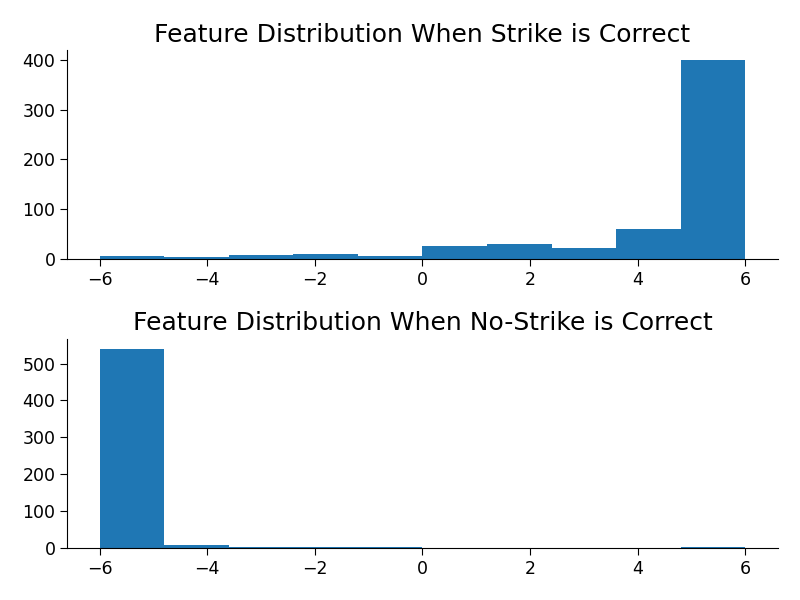

In [14]:
# and for scalar data always good to look at a histogram
fig, (ax1, ax2) = plt.subplots(2, 1)
remove_ip_clutter(fig)
ax1.hist(X_simple_1_feature[y1_simple.flatten() == 1])
ax1.set_title('Feature Distribution When Strike is Correct')
ax2.hist(X_simple_1_feature[y1_simple.flatten() == 0])
ax2.set_title('Feature Distribution When No-Strike is Correct')
plt.show()

Looking at the distribution of the input values across these two classes (strike vs. no-strike situations), we see that we should be able to correctly discriminate between these two cases most of the time. Perhaps the simplest decision rule that could be used in a situation like this is a 'threshold' decision rule. Looking at the histograms above, a good threshold would be one where the organism stirkes if the input value is above the threshold and does not strike if the input value is below the threshold. For now we leave aside how an organism might actually learn such a threshold from experience, and simply ask, what is the optimal such threhold value, given this particular set of $\text{input}, \text{output}$ pairs.

Let's use our perturb-measure-step optimization procedure to find the optimal threshold for discriminating between these two cases. A very low threshold means the predator strikes at everything, and a very high threshold means the predator strikes at nothing. The predator recieves a reward of one when it successfully strikes and a reward of negative one if it strikes when prey is not present. If it does not strike it recieves a reward of zero regardless of whether or not prey was present. Give these rewards, and the background prevalance of prey, and the two distributions of the feature when prey is present or absent what will the optimal threshold be

In [15]:
# @title Dialing in The Optimal Threshold

class InteractiveThresholdDialer:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r = 1
    self.false_strike_r = -1
    self.correct_non_strike_r = 0
    self.false_non_strike_r = 0
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.threshold_slider = widgets.FloatSlider(
        value=0, min=self.bounds[0], max=self.bounds[1], step=0.1,
        description='Threshold:', readout=True, readout_format='.2f')
    self.fig, (self.hist_ax, self.r_ax) = plt.subplots(2, 1, figsize=(8, 6),
                                                       sharex=True)
    self.narration_display = widgets.Output()
    self.init_plot()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    self.ui = widgets.VBox([
        widgets.HBox([self.fig.canvas,]),
        widgets.HBox([self.threshold_slider, self.narration_display])
    ])
    self.threshold_slider.observe(self.on_threshold_slider_changed, 'value')
    print("We have narration display", hasattr(self, 'narration_display'))


  def eval_threshold(self, t):
    t = np.asarray(t).reshape(1, -1)  # 1 x len(t)
    features = self.features.reshape(-1, 1)  # len(features) x 1
    labels = self.labels.reshape(-1, 1)  # len(labels) x 1
    strikes = features > t # len(features) x len(t)
    non_strikes = features <= t # len(feature) x len(t)
    should_strike = labels == 1 # len(labels) x 1
    should_not_strike = labels == 0 #len(labels) x 1

    correct_strikes = strikes & should_strike #len(labels/features) x len(t)
    false_strikes = strikes & should_not_strike #len(labels/features) x len(t)
    correct_non_strikes = non_strikes & should_not_strike #len(labels/features) x len(t)
    false_non_strikes = non_strikes & should_strike #len(labels/features) x len(t)

    r = (self.correct_strike_r * np.sum(correct_strikes, axis=0) +
         self.false_strike_r * np.sum(false_strikes, axis=0) +
         self.correct_non_strike_r * np.sum(correct_non_strikes, axis=0) +
         self.false_non_strike_r * np.sum(false_non_strikes, axis=0))
    r = r.flatten()
    if len(r) == 1:
      r = r[0]
      # for single threshold evaluations
      num_correct_strikes = np.sum(correct_strikes)
      num_false_strikes = np.sum(false_strikes)
      num_correct_non_strikes = np.sum(correct_non_strikes)
      num_false_non_strikes = np.sum(false_non_strikes)
      # Prepare a text-based confusion matrix
      confusion_matrix_data = [
          ["Should Strike", num_correct_strikes, num_false_non_strikes],
          ["Should Not Strike", num_false_strikes, num_correct_non_strikes]]
      headers = ["", "Will Strike", "Will Not Strike"]
      confusion_matrix_table = tabulate(confusion_matrix_data, headers, tablefmt="grid")
      message = f"Confusion Matrix for threshold {t[0][0]:.2f}:\n{confusion_matrix_table}\n\nTotal Reward: {r}"
      self.narration_display.clear_output(wait=True)
      with self.narration_display:
        clear_output()
        print(message)
    return r

  def on_threshold_slider_changed(self, change):
    self.plot_threshold(self.threshold_slider.value)
    self.fig.canvas.draw_idle()

  def plot_threshold(self, t):
    r = self.eval_threshold(t)
    self.threshold_vline.set_data([t, t], [0, r])
    y_min, y_max = self.hist_ax.get_ylim()
    self.hist_vline.set_data([t, t], [y_min, y_max])

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.eval_threshold(t_vals)
    # Initial plot commands return line objects, keep references to them
    self.threshold_vline, = self.r_ax.plot([],[] ,color='r', linestyle='--', label='Threshold')
    self.hist_vline, = self.hist_ax.plot([], [], color='r', linestyle='--', label='Threshold')
    self.reward_curve, = self.r_ax.plot(t_vals, r_vals, alpha=1.0, label='Expected Reward')
    self.hist_ax.hist(self.features[self.labels.flatten() == 1], alpha=0.5, label='Strike')
    self.hist_ax.hist(self.features[self.labels.flatten() == 0], alpha=0.5, label='No Strike')
    self.hist_ax.set_xlabel('Feature Value')
    self.hist_ax.set_ylabel('Counts')

    self.fig.suptitle('Threshold Evaluation')
    self.r_ax.set_xlabel('Threshold')
    self.r_ax.set_ylabel('Total Reward\n(Over 1125 trials)')
    self.plot_threshold(self.threshold_slider.value)
    self.hist_ax.legend()
    self.r_ax.legend()
    self.fig.canvas.draw_idle()



itd = InteractiveThresholdDialer()
display(itd.fig.canvas)
clear_output()
display(itd.ui)

By playing with the threshold slider in the widget above you can see how there is a fundamental trade-off between missing opportunities to strike prey and avoiding false-strikes. In a binary discrimination task like this (or any categorization task) a very useful form of feedback is the *confusion matrix*. The confusion matrix gives so much more information than just how many correct and in incorrect categorizations the decision rule made, it shows exactly which categories are being confused with which. The confusion matrix, together with the relative rewards(costs) for the different types of correct and incorrect classifications determine what the optimal trade-off between missed opportunities and failed strikes will be.  Let's now see if our Perturb-Measure-Step approach can find this optimal trade-off.

In [16]:
# @title Optimal Stike-No-Stike Threshold with Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the optimal strike-no-stike threshold our perturb-measure-step approach.
class InteractiveThresholdSlopeStepper:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple,
               test_size=0.1,
               step_size=0.2,
               adjustable_step_size=False,
               seed=None):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r = 1
    self.false_strike_r = -1
    self.correct_non_strike_r = 0
    self.false_non_strike_r = 0
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.test_step_slider = widgets.FloatSlider(
        value=test_size, min=-1.5, max=1.5, step=0.1,
        description='Test Step:', readout=True, readout_format='.2f')
    self.t_step_slider = widgets.FloatSlider(
        value=step_size, min=0.005, max=0.5, step=0.005,
        description='t Step:', readout=True, readout_format='.2f')
    self.adjustable_step_size = adjustable_step_size
    self.rng = np.random.default_rng(seed)
    self.current_t = self.rng.uniform(self.bounds[0], self.bounds[1])[0]
    self.current_r = self.eval_threshold(self.current_t)
    self.test_t = None
    self.test_r = None
    self.step_t = None
    self.step_r = None
    self.t_history = []
    self.r_history = []
    self.points_tested = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))

    self.perturb = widgets.Button(description='Perturb')
    self.measure = widgets.Button(description='Measure')
    self.measure.disabled = True
    self.step = widgets.Button(description='Step')
    self.step.disabled = True

    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=True, description='Show Curve')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    if self.adjustable_step_size:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        self.test_step_slider,
        self.t_step_slider,
        widgets.HBox([self.reset, self.show_history])])
    else:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])

    #bind actions to handlers
    self.perturb.on_click(self.on_perturb_clicked)
    self.measure.on_click(self.on_measure_clicked)
    self.step.on_click(self.on_step_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')
    self.t_step_slider.observe(self.on_t_step_slider_changed, 'value')
    self.test_step_slider.observe(self.on_test_step_slider_changed, 'value')

  def eval_threshold(self, t):
    t = np.asarray(t).reshape(1, -1)  # 1 x len(t)
    features = self.features.reshape(-1, 1)  # len(features) x 1
    labels = self.labels.reshape(-1, 1)  # len(labels) x 1
    strikes = features > t # len(features) x len(t)
    non_strikes = features <= t # len(feature) x len(t)
    should_strike = labels == 1 # len(labels) x 1
    should_not_strike = labels == 0 #len(labels) x 1

    correct_strikes = strikes & should_strike #len(labels/features) x len(t)
    false_strikes = strikes & should_not_strike #len(labels/features) x len(t)
    correct_non_strikes = non_strikes & should_not_strike #len(labels/features) x len(t)
    false_non_strikes = non_strikes & should_strike #len(labels/features) x len(t)

    r = (self.correct_strike_r * np.sum(correct_strikes, axis=0) +
         self.false_strike_r * np.sum(false_strikes, axis=0) +
         self.correct_non_strike_r * np.sum(correct_non_strikes, axis=0) +
         self.false_non_strike_r * np.sum(false_non_strikes, axis=0))
    r = r.flatten()
    if len(r) == 1:
      r = r[0]
    return r

  def on_t_step_slider_changed(self, change):
    self.step_t = self.current_t + self.t_step_slider.value * self.slope
    self.step_r = self.slope * self.step_t + self.y_intercept
    self.step_point.set_data([self.step_t], [self.step_r])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_t, self.step_t], [y_min, self.step_r])
    self.fig.canvas.draw_idle()

  def on_test_step_slider_changed(self, change):
    if self.test_step_slider.value == 0:
      # Set to a default non-zero value
      self.test_step_slider.value = 0.01
      with self.narration_display:
        print(f"Test step size of 0 cannot be used to calculate slope. Using 0.01 to avoid division by zero in slope calculation.")
    self.test_t = self.current_t + self.test_step_slider.value
    self.test_r = self.eval_threshold(self.test_t)
    self.test_point.set_data([self.test_t], [self.test_r])
    if self.step_t is not None:
      rise = self.test_r - self.current_r
      run = self.test_t - self.current_t
      self.slope = rise / run
      self.y_intercept = self.current_r - self.slope * self.current_t
      t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
      r_vals = self.slope * t_vals + self.y_intercept
      self.step_line.set_data(t_vals, r_vals)
      self.step_t = self.current_t + self.t_step_slider.value * self.slope
      self.step_r = self.slope * self.step_t + self.y_intercept
      self.step_point.set_data([self.step_t], [self.step_r])
      y_min, y_max = self.ax.get_ylim()
      self.step_vline.set_data([self.step_t, self.step_r], [y_min, self.step_r])
    self.fig.canvas.draw_idle()

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.eval_threshold(t_vals)
    # Initial plot commands return line objects, keep references to them
    self.point_current, = self.ax.plot([self.current_t], [self.current_r], 'bo', label='Current')
    self.test_point, = self.ax.plot([], [], 'rx', label='Test Point')  # Empty data to start
    self.step_point, = self.ax.plot([], [], 'go', label='Step Point')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.line_polynomial, = self.ax.plot(t_vals, r_vals, alpha=1.0, label='Polynomial Curve')
    self.slope = 0
    self.y_intercept = self.current_r - self.slope * self.current_t
    self.step_line, = self.ax.plot([], [], 'r', label='Measure')
    self.step_vline, = self.ax.plot([], [], 'g', linestyle='--')
    self.ax.set_title('Threshold Evaluation')
    self.ax.set_xlabel('Threshold')
    self.ax.set_ylabel('Total Reward\n(Over 1125 trials)')
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button):
    self.points_tested += 1
    self.test_t = self.current_t + self.test_step_slider.value
    self.test_r = self.eval_threshold(self.test_t)
    self.test_point.set_data([self.test_t], [self.test_r])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test t: {self.test_t:.3f}, y: {self.test_r:.3f}.')
      print(f'Current t: {self.current_t:.3f}, r: {self.current_r:.3f}.')
      print("Click measure to evaluate the slope based on this test point")
    self.measure.disabled = False
    self.perturb.disabled = True

  def on_measure_clicked(self, button):
    rise = self.test_r - self.current_r
    run = self.test_t - self.current_t
    self.slope = rise / run
    self.y_intercept = self.current_r - self.slope * self.current_t
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.slope * t_vals + self.y_intercept
    self.step_line.set_data(t_vals, r_vals)
    self.step_t = self.current_t + self.t_step_slider.value * self.slope
    self.step_r = self.slope * self.step_t + self.y_intercept
    self.step_point.set_data([self.step_t], [self.step_r])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_t, self.step_t], [y_min, self.step_r])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Based on slope measurement proposed step from {self.current_t:.3f} to {self.step_t:.3f}')
      print("Click step, to make the step.")

    self.step.disabled = False
    self.measure.disabled = True

  def on_step_clicked(self, button):
    new_r = self.eval_threshold(self.step_t)
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to t: {self.step_t:.3f}')
      print(f'Actual reward for this threshold is {new_r:.3f}')
      print(f'Click perturb to test a new threshold.')
    self.t_history.append(self.current_t)
    self.r_history.append(self.current_r)
    self.points_history.set_data(self.t_history, self.r_history)
    self.current_t = self.step_t
    self.current_r = new_r
    self.point_current.set_data([self.current_t], [self.current_r])
    self.test_t = None
    self.test_r = None
    self.test_point.set_data([], [])
    self.step_t = None
    self.step_r = None
    self.step_point.set_data([], [])
    self.step_line.set_data([], [])
    self.step_vline.set_data([], [])
    self.fig.canvas.draw_idle()
    self.step.disabled = True
    self.perturb.disabled = False

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Still using the same features and labels though')
    self.current_t = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_r = self.eval_threshold(self.current_x)
    self.test_t = None
    self.test_r = None
    self.step_t = None
    self.step_r = None
    self.t_history = []
    self.r_history = []
    self.step.disabled = True
    self.perturb.disabled = False
    self.point_current.set_data([self.current_t], [self.current_r])
    self.points_history.set_data(self.t_history, self.r_history)
    self.test_point.set_data([], [])
    self.step_point.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



itss = InteractiveThresholdSlopeStepper()
display(itss.fig.canvas)
clear_output()
display(itss.ui)

This likely isn't working very well for you. The reason for this is that unlike the polynomial we first worked with, this threshold based striking policy does not change smoothly in the average rewards. Rather, the reward is a step function of the threshold. THhis means that whole ranges of threshold values result in exactly the same average reward. There are ways of smoothing out such functions, but for now let's see if we can salvage our perturb-measure-step approach by taking perturbations that are big enough to step outside of the flat bits.

In [17]:
# @markdown **Run this cell** to try Perturb-Measure-Step again with adjustable step sizes.
itssv = InteractiveThresholdSlopeStepper(adjustable_step_size=True)
display(itssv.fig.canvas)
clear_output()
display(itssv.ui)

So here we have a bit of an issue. To overcome the flat step-wise nature reward as a function of threshold and make any progress we have to take big test steps, but big test steps ultimately limit how precisely we can dial in the actual optimal threshold value. This sort of fragility and fiddlyness is something that can be overcome, either by having test and parameter step sizes vary to match the scale of the reward function, in particular its step widths. In the next sequence we explore a powerful and widespread method of overcoming this kind of issue. For now though we conclude with the following thoughts.

We touched breifly on three different approaches to optimization in this sequence.

The first was an analytic approach, in which we used total knowledge of the problem together with mathematical super-powers like taking derivatives and solving systems of linear equations to determine an optimal point.

The second was almost the opposite, a very simple try and see approach which we've been calling propose and reject. We don't need to know anything about derivative or algebra to implement this, we just need to be able to evaluate differences in performance between two different points, and then switch when a new point is better than the previous best. This seems to be the minimum viable optimization process, and is roughly the kind of "optimization" that evolution by natural selection is performing, i.e. try new things that are slightly different from the previous things, select the things that performed better to continue the process with.

The third approach was somewhere in between the two. We noted that the propose and reject approach can be very inefficient from a computational perspective; in our simple one dimensional problem on average half of all proposals were rejected. We came up with a middle ground approach that slightly extended the computational complexity of the propose and reject mechanism, instead of using the comparison between the new and old point to decide whether to jump to the new point, we instead used the comparisong between the new and old point to estimate the slope of the reward at the current point, and then step to a new point based on this slope estimate. We think of this as itermediate, because it uses (an estimate) of the gradient like the first analytic approach, but instead of requiring full knowledge and math super-powers, this approach only required slightly more computational complexity than propose and reject.

In [18]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M4")

# Quiz

In [19]:
# @markdown **Run this cell** to take the quiz
comprehension_quiz = [
  {
    "question": "How does the complexity of a neural circuit (number of parameters) impact the number of learning iterations and hence time to learn using a 'measure and update' learning process?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It does not affect the number of iterations required; the process scales well regardless of circuit complexity.",
        "correct": False,
        "feedback": "Actually, the the number of iterations required grows with the complexity of the circuit due to more parameters requiring optimization."
      },
      {
        "answer": "The process requires few learning iterations, by leveraging algorithmic economies of scale",
        "correct": False,
        "feedback": "Contrary to this, an increase in parameters leads the more learning iterations being required."
      },
      {
        "answer": "The process becomes requires more learning episodes for larger, more complex circuits.",
        "correct": True,
        "feedback": "Correct! More parameters mean more complexity and thus more learning episodes are needed."
      },
      {
        "answer": "The number of learning iterations needed is solely dependent on the type of learning task, not the circuit complexity.",
        "correct": False,
        "feedback": "Circuit complexity, particularly the number of parameters, plays a significant role in the number of learning iterations needed."
      }
    ]
  },
  {
    "question": "Why was the introduction of a 'hidden layer' beneficial in our complex discrimination tasks?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It allowed the model to perform tasks more quickly but with reduced accuracy.",
        "correct": False,
        "feedback": "The hidden layer's primary benefit is not speed at the cost of accuracy, but rather an enhancement in handling complex patterns."
      },
      {
        "answer": "It introduces feature interactions and non-linearities, enabling the model to capture complex patterns.",
        "correct": True,
        "feedback": "Exactly! Hidden layers allow for complex interactions and non-linear processing of features, which can be crucial for generating behaviour contingent on rich sensory input."
      },
      {
        "answer": "It reduces the number of parameters needed, simplifying the model.",
        "correct": False,
        "feedback": "Adding a hidden layer typically increases the number of parameters, adding complexity to the model."
      },
      {
        "answer": "It primarily improves the model's visualization, making it easier to interpret.",
        "correct": False,
        "feedback": "While interpretability is important, this is not an advantage of adding a hidden layer."
      }
    ]
  },
  {
    "question": "In the context of machine learning, what is the impact of using a 'mini-batch' approach?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It guarantees a 10x speedup in learning algorithms.",
        "correct": False,
        "feedback": "While mini-batches can speed up learning, the magnitude of this speed-up will depend on choice of mini-batch size and the interaction of this size with underlying algorithmic efficiencies of scale at the hardware implementation level."
      },
      {
        "answer": "It reduces the time for evaluations by using a smaller, representative data sample.",
        "correct": True,
        "feedback": "Correct! A mini-batch approach uses a smaller subset of data for quicker evaluations, though it introduces some noise to the estimates."
      },
      {
        "answer": "It decreases the accuracy of parameter evaluation",
        "correct": True,
        "feedback": "Correct! Mini-batches do introduce some noise to parameter evaluation, but is used thoughtfully this usually isn't an issue."
      },
      {
        "answer": "It eliminates the need for parameter updates in the learning process.",
        "correct": False,
        "feedback": "Mini-batches still require parameter updates; they just alter the way data is processed during learning."
      }
    ]
  },
  {
    "question": "What challenge arises when comparing different machine learning algorithms?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "Algorithms cannot be compared due to their differing objectives.",
        "correct": False,
        "feedback": "While objectives can vary, this doesn't make comparison impossible; it's more about how different parameters and conditions affect performance."
      },
      {
        "answer": "All algorithms perform similarly when given the same data and task.",
        "correct": False,
        "feedback": "Performance can vary significantly between algorithms depending on their design and the specificities of the task and data."
      },
      {
        "answer": "Performance is highly dependent on meta-parameter choices, making direct comparisons challenging.",
        "correct": True,
        "feedback": "Variations in learning rate, perturbation scale, mini-batch size, and other meta-parameters can significantly impact algorithm performance, complicating direct comparisons."
      },
      {
        "answer": "Algorithms' performance cannot be measured or quantified.",
        "correct": False,
        "feedback": "Performance can indeed be measured and quantified, but the challenge lies in accounting for differences in meta-parameters and conditions."
      }
    ]
  }
]

display_quiz(comprehension_quiz)

<IPython.core.display.Javascript object>